In [1]:
import matplotlib.pyplot as plt
import matplotlib as mlp
import numpy as np
import uproot
import os
import glob
import awkward as ak
import subprocess
plt.rcParams["xtick.top"] = True    # enable top x-ticks
plt.rcParams["ytick.right"] = True  # enable right y-ticks
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

In [2]:
sp_path = "/home/haue/repositories/Masters/data/singleprotons/Al/inclbetacut/"
sp_files = glob.glob(os.path.join(sp_path, "*mlio.root"))
twop_path = "/home/haue/repositories/Masters/data/twoproton/Al/"
twop_files = glob.glob(os.path.join(twop_path, "*mlio.root"))
scale = 3.326542500626603
scale_2p = 5.144862255824787
diff_scales = 1.546609506674175

E2 = np.array([])
for batch in uproot.iterate(sp_files, expressions=["E"],
                            cut="(id>0) & (id<4)"):
    E2 = np.append(E2, ak.flatten(batch.E))
    
E2p_tot = np.array([])
for batch in uproot.iterate(twop_files, expressions=["E"]):
    E2p_tot=np.append(E2p_tot, ak.flatten(batch.E))
    
E2p = np.array([])
for batch in uproot.iterate(twop_files, expressions=["E"],
                            cut="(id>0) & (id<4)"):
    E2p=np.append(E2p, ak.flatten(batch.E))
bins = np.arange(0, 9000+10, 10)
counts_E2, _ = np.histogram(E2, bins=bins)
counts_E2p, _ = np.histogram(E2p, bins=bins)
Es = counts_E2 - scale * counts_E2p
Es = np.maximum(Es, 0)
errors_Es = np.sqrt(counts_E2p + (scale**2) * counts_E2)
bin_centers = bins[:-1] + 0.5 * (bins[1] - bins[0])
###
counts_E2p_tot, _ = np.histogram(E2p_tot, bins=bins)
Es_tot = counts_E2 - scale/diff_scales * counts_E2p_tot
Es_tot = np.maximum(Es_tot, 0)
errors_Es_tot = np.sqrt(counts_E2p_tot + ((scale/diff_scales)**2) * counts_E2)
###
E = np.repeat(bin_centers,np.asarray(Es).astype(int))
E_errors = np.repeat(bin_centers,np.asarray(errors_Es).astype(int))
E_tot = np.repeat(bin_centers,np.asarray(Es_tot).astype(int))
E_tot_errors = np.repeat(bin_centers,np.asarray(errors_Es_tot).astype(int))

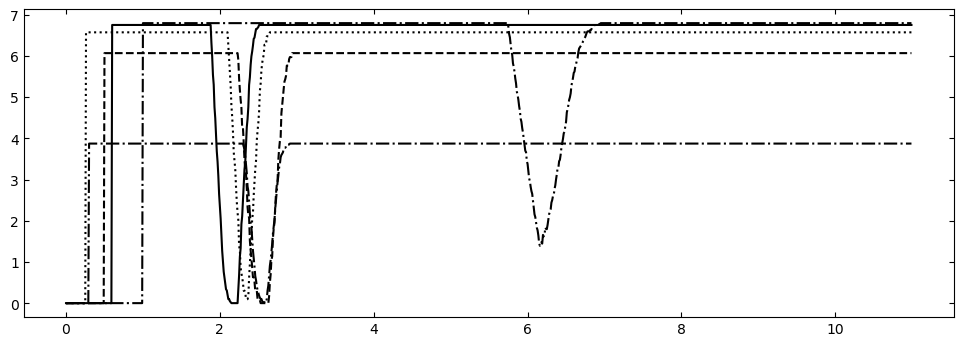

In [3]:
Elin = np.arange(0., 11000., 10.)
sac = np.array([])
curdir = os.getcwd()
os.chdir("/home/haue/repositories/Masters/analysis/python/twoproton")
for dssd, ssd, cutoff, thresh in zip(
    ["U1", "U2", "U3", "U4", "U6"], ["P1", "P2", "P3", "P4", "P6"], [600, 500, 260, 1000, 300], [280, 340, 180, 350, 220]): # P6 thresh: 220
    filename = "sam_21al_%s.dat" % dssd
    if not os.path.exists(filename):
        f = open(filename, "w")
        subprocess.call(["SAM", "-i45", "-d%s" % dssd], cwd="/home/haue/repositories/Masters/setup", stdout=f)
        f.close()
    sr = np.loadtxt(filename)
    #im = plt.imshow(100*np.transpose(sr)/(4*np.pi), extent=[0.5, 16.5, 16.5, 0.5], vmin=0., cmap=plt.cm.inferno)
    #cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    #plt.show()
    
    filename = "tdz_21al_%s.dat" % dssd
    if not os.path.exists(filename):
        f = open(filename, "w")
        subprocess.call(["TDZ", "-d%s,%s" % (dssd, ssd), "-i45", "--threshold=%s" % str(thresh)], cwd="/home/haue/repositories/Masters/setup/", stdout=f)
        f.close()
    
    v, fEdepmax, Elow, Eupp, fEdeplow, Esplow = np.loadtxt(filename, unpack=True)
    for i in range(len(Elin)):
        val = 0.
        if Elin[i] < cutoff:
#             print(Elin[i])
            sac = np.append(sac, val)
        else:
            # do not include outermost strips
            for j in range(0+1, 16-1):
                for k in range(0+1, 16-1):
                    if Esplow[j*16 + k] < Elin[i] and Elin[i] < Eupp[j*16 + k]:
#                         print(j, k, Elin[i])
                        pass
                    else:
                        val += sr[j, k]
            sac = np.append(sac, val)
            
os.chdir(curdir)     
sac_ = 100*sac/(4*np.pi)
sac1 = sac_[0:len(Elin)]
sac2 = sac_[len(Elin):2*len(Elin)]
sac3 = sac_[2*len(Elin):3*len(Elin)]
sac4 = sac_[3*len(Elin):4*len(Elin)]
sac6 = sac_[4*len(Elin):5*len(Elin)]
plt.figure(figsize=(12,4))
plt.plot(Elin/1e3, sac1, 'k-', label='U1-P1')
plt.plot(Elin/1e3, sac2, 'k--', label='U2-P2')
plt.plot(Elin/1e3, sac3, 'k:', label='U3-P3')
plt.plot(Elin/1e3, sac4, 'k-.', label='U4-P4')
plt.plot(Elin/1e3, sac6, 'k-.', label='U6-P6')

In [4]:
all = np.max(sac2)+np.max(sac3)+np.max(sac4)+np.max(sac1)+np.max(sac6)
i = np.max(sac2)+np.max(sac3)+np.max(sac4)
100/all, 100/i, all/i, i/all, i/all*scale

(3.326542500626603,
 5.144862255824787,
 1.546609506674175,
 0.6465756195630773,
 2.1508612783455545)

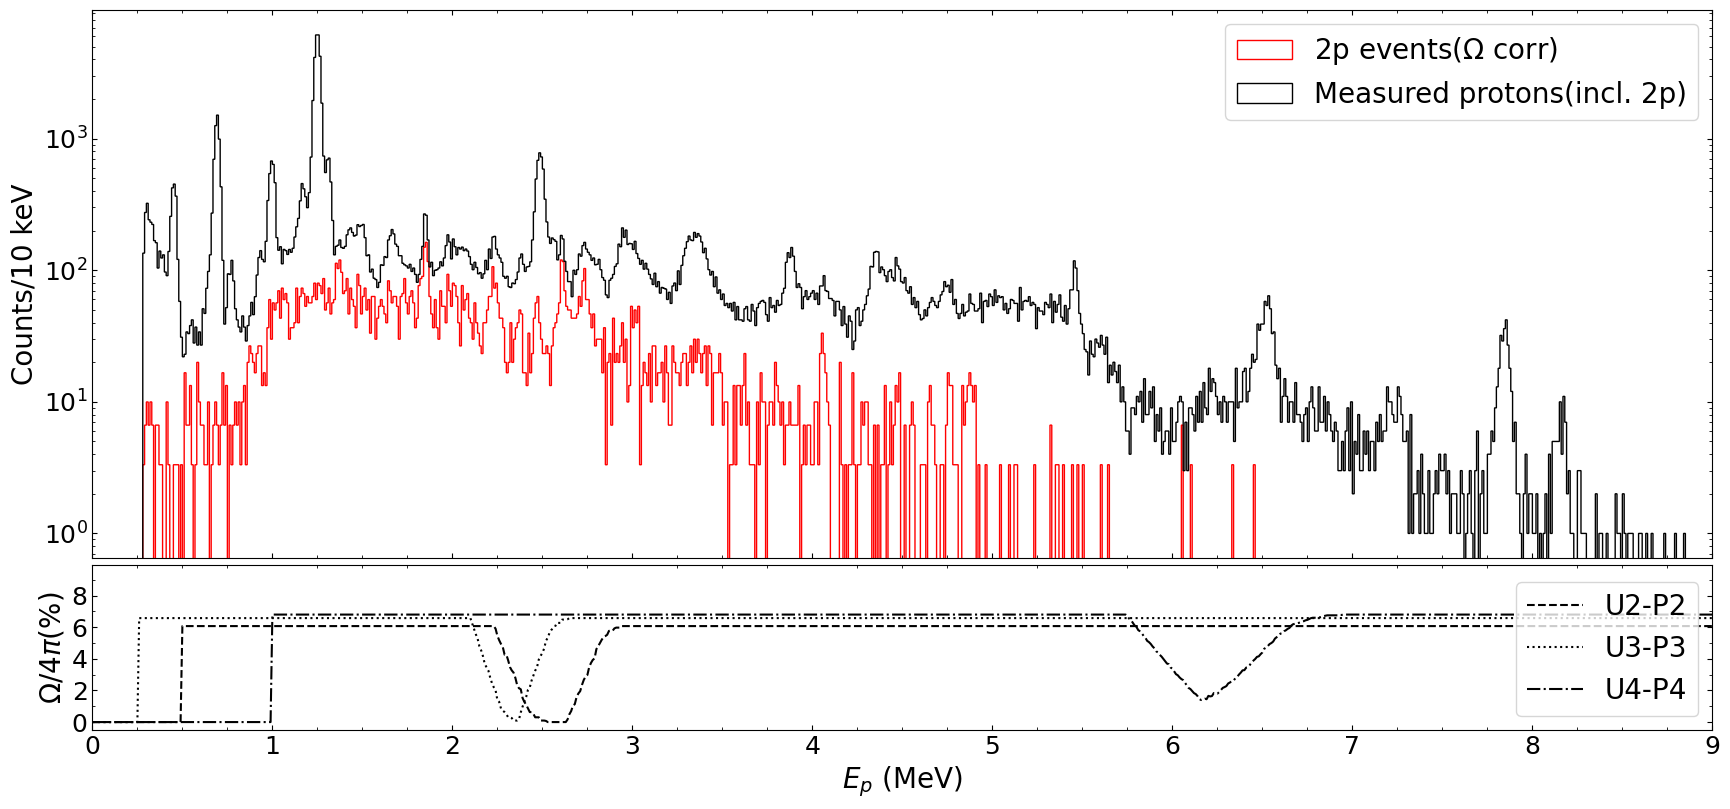

In [ ]:
fs = 20
fs_ticks = 18
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(18, 8),gridspec_kw={'height_ratios': [1, 0.3]},sharex=True)
plt.subplots_adjust(hspace=0.02, top=0.96, bottom=0.06, left=0.08, right=0.98)

twoscale = 100/(np.max(sac2)+np.max(sac3)+np.max(sac4))

ax0 = axes[0]
ax0.hist(E2p/1e3, bins=np.arange(0, 9+0.01, 0.01), histtype='step', color='r', label=r"2p events($\Omega$ corr)",weights=scale*np.ones(len(E2p)))
ax0.hist(E2/1e3, bins=np.arange(0, 9+0.01, 0.01), histtype='step', color='k', label="Measured protons(incl. 2p)")
ax0.set_ylabel("Counts/10 keV", fontsize=fs)
ax0.set_yscale('log')
ax0.legend(fontsize=fs, loc='upper right')
ax0.tick_params(axis='x', bottom=True, top=True, labelbottom=False, labeltop=False, labelsize=fs_ticks, direction='in')

#ax0.set_title("Proton spectrum for U2-U4")


ax1 = axes[1]
ax1.plot(Elin/1e3, sac2, 'k--', label='U2-P2')
ax1.plot(Elin/1e3, sac3, 'k:',  label='U3-P3')
ax1.plot(Elin/1e3, sac4, 'k-.', label='U4-P4')
ax1.set_xlabel(r"$E_p$ (MeV)", fontsize=fs)
ax1.set_ylabel(r"$\Omega$/4$\pi$(%)", fontsize=fs)
ax1.legend(fontsize=fs, loc='lower right')
ax1.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=fs_ticks, direction='in')
ax1.tick_params(axis='y', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=fs_ticks, direction='in')
ax1.set_yticks(np.arange(0,10,1), minor=True)
ax1.set_yticks(np.arange(0,10,2))
ax1.set_xticks(np.arange(-1,10,1))
ax1.set_xticks(np.arange(-1,10,0.25), minor=True,)

ax1.set_ylim(-0.5,9.9)
ax0.set_xlim(0, 9)


ax0.tick_params(axis='both', which='major', labelsize=fs_ticks, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=fs_ticks, direction='in')
plt.savefig("full+2p.pdf")
plt.show()


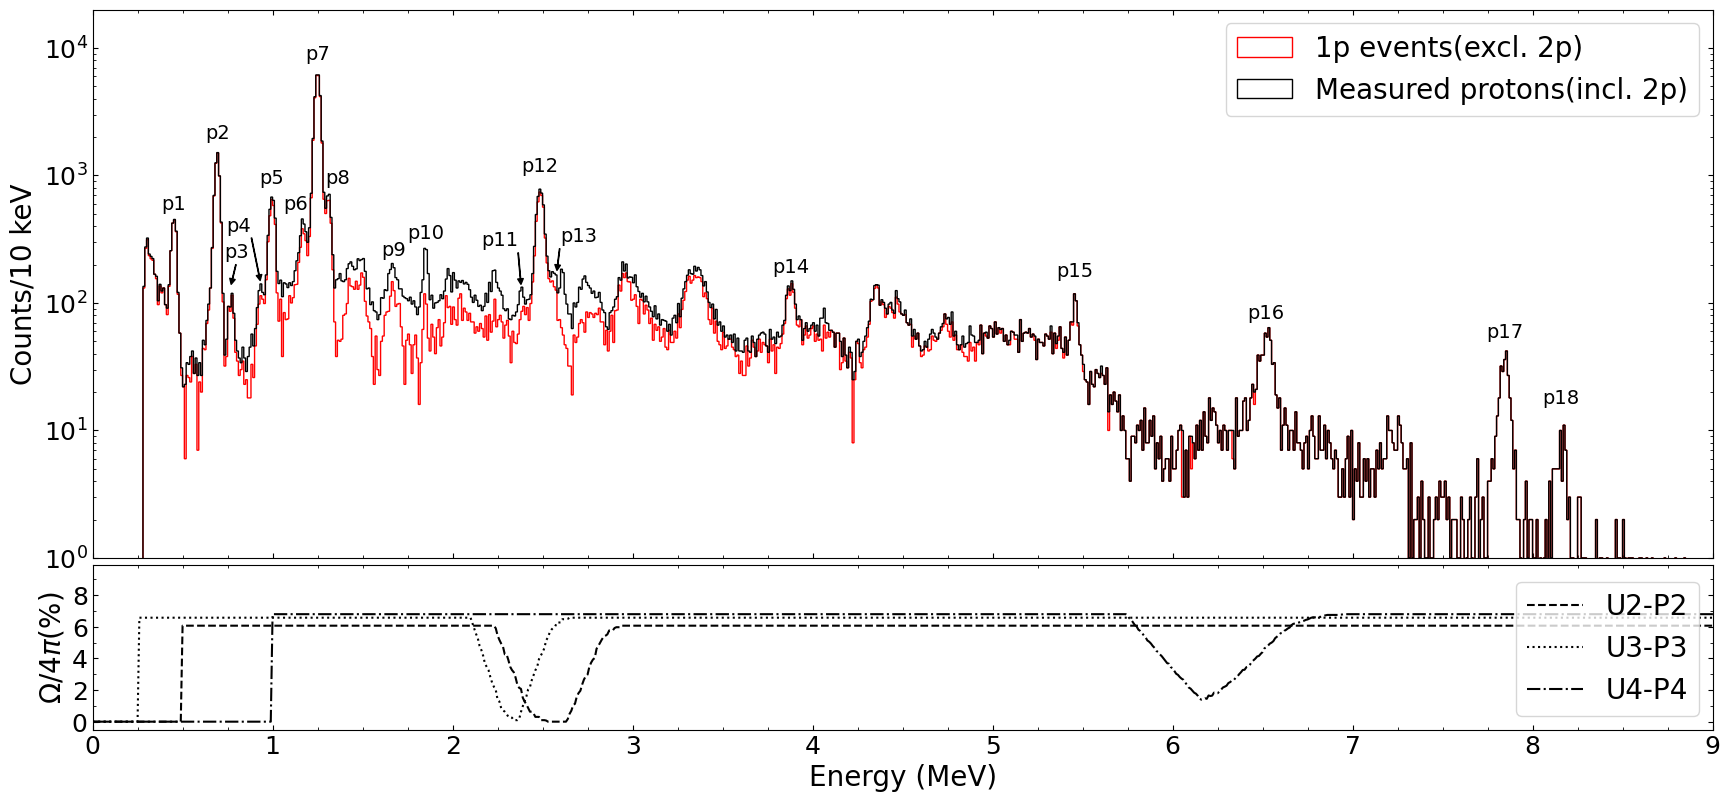

In [19]:
fs = 20
fs_ticks = 18
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(18, 8),gridspec_kw={'height_ratios': [1, 0.3]},sharex=True)
plt.subplots_adjust(hspace=0.02, top=0.96, bottom=0.06, left=0.08, right=0.98)

twoscale = 100/(np.max(sac2)+np.max(sac3)+np.max(sac4))

ax0 = axes[0]
ax0.hist(E/1e3, bins=np.arange(0, 9+0.01, 0.01), histtype='step', color='r', label="1p events(excl. 2p)")
ax0.hist(E2/1e3, bins=np.arange(0, 9+0.01, 0.01), histtype='step', color='k', label="Measured protons(incl. 2p)")
ax0.set_ylabel("Counts/10 keV", fontsize=fs)
ax0.set_yscale('log')
ax0.legend(fontsize=fs, loc='upper right')
ax0.tick_params(axis='x', bottom=True, top=True, labelbottom=False, labeltop=False, labelsize=fs_ticks, direction='in')


ax1 = axes[1]
ax1.plot(Elin/1e3, sac2, 'k--', label='U2-P2')
ax1.plot(Elin/1e3, sac3, 'k:',  label='U3-P3')
ax1.plot(Elin/1e3, sac4, 'k-.', label='U4-P4')
ax1.set_xlabel("Energy (MeV)", fontsize=fs)
ax1.set_ylabel(r"$\Omega$/4$\pi$(%)", fontsize=fs)
ax1.legend(fontsize=fs, loc='lower right')
ax1.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=fs_ticks, direction='in')
ax1.tick_params(axis='y', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=fs_ticks, direction='in')
ax1.set_yticks(np.arange(0,10,1), minor=True)
ax1.set_yticks(np.arange(0,10,2))
ax1.set_xticks(np.arange(-1,10,1))
ax1.set_xticks(np.arange(-1,10,0.25), minor=True)

ax1.set_ylim(-0.5,9.9)
ax0.set_xlim(0, 9)
ax0.set_ylim(1, 2e4)

ax0.tick_params(axis='both', which='major', labelsize=fs_ticks)
ax1.tick_params(axis='both', which='major', labelsize=fs_ticks)


es = [0.452, 0.692,0.770,0.931, 0.995, 1.130, 1.250, 1.360, 1.673, 1.850, 2.38, 2.486, 2.580,
      3.877, 5.456, 6.520, 7.844, 8.158]
arrow = [0.5*1e3, 1.8e3, (1.4e2,2.1e2,"cent"), (1.5e2, 3.4e2, "left"), 0.8e3, 0.5e3, 0.75e4, 0.8e3, 0.22e3, 0.3e3, (1.4e2,2.6e2, "left"), 1e3, (1.8e2,2.8e2, "right"),
         1.6e2, 1.5e2, 0.7e2, 0.5e2, 0.15e2]
i = 1
for e,a in zip(es,arrow):
    if isinstance(a, tuple):
        if a[2] == "left":
            ax0.annotate(f"p{i}", xy=(e, a[0]), xytext=(e-0.12, a[1]), arrowprops=dict(facecolor='k', edgecolor='k', width=0.3, headwidth=4, headlength=4), ha='center', va='bottom', fontsize=14, color='k')
        if a[2] == "right":
            ax0.annotate(f"p{i}", xy=(e, a[0]), xytext=(e+0.12, a[1]), arrowprops=dict(facecolor='k', edgecolor='k', width=0.3, headwidth=4, headlength=4), ha='center', va='bottom', fontsize=14, color='k')
        if a[2] == "cent":
            ax0.annotate(f"p{i}", xy=(e, a[0]), xytext=(e+0.03, a[1]), arrowprops=dict(facecolor='k', edgecolor='k', width=0.3, headwidth=4, headlength=4), ha='center', va='bottom', fontsize=14, color='k')
    else:
        ax0.annotate(f"p{i}", xy=(e, a), ha='center', va='bottom', fontsize=14, color='k')#, xytext=(e, a[1]), arrowprops=dict(facecolor='k', edgecolor='k', width=0.3, headwidth=4, headlength=4))
    i+=1

plt.savefig("1psingles.pdf")
plt.show()

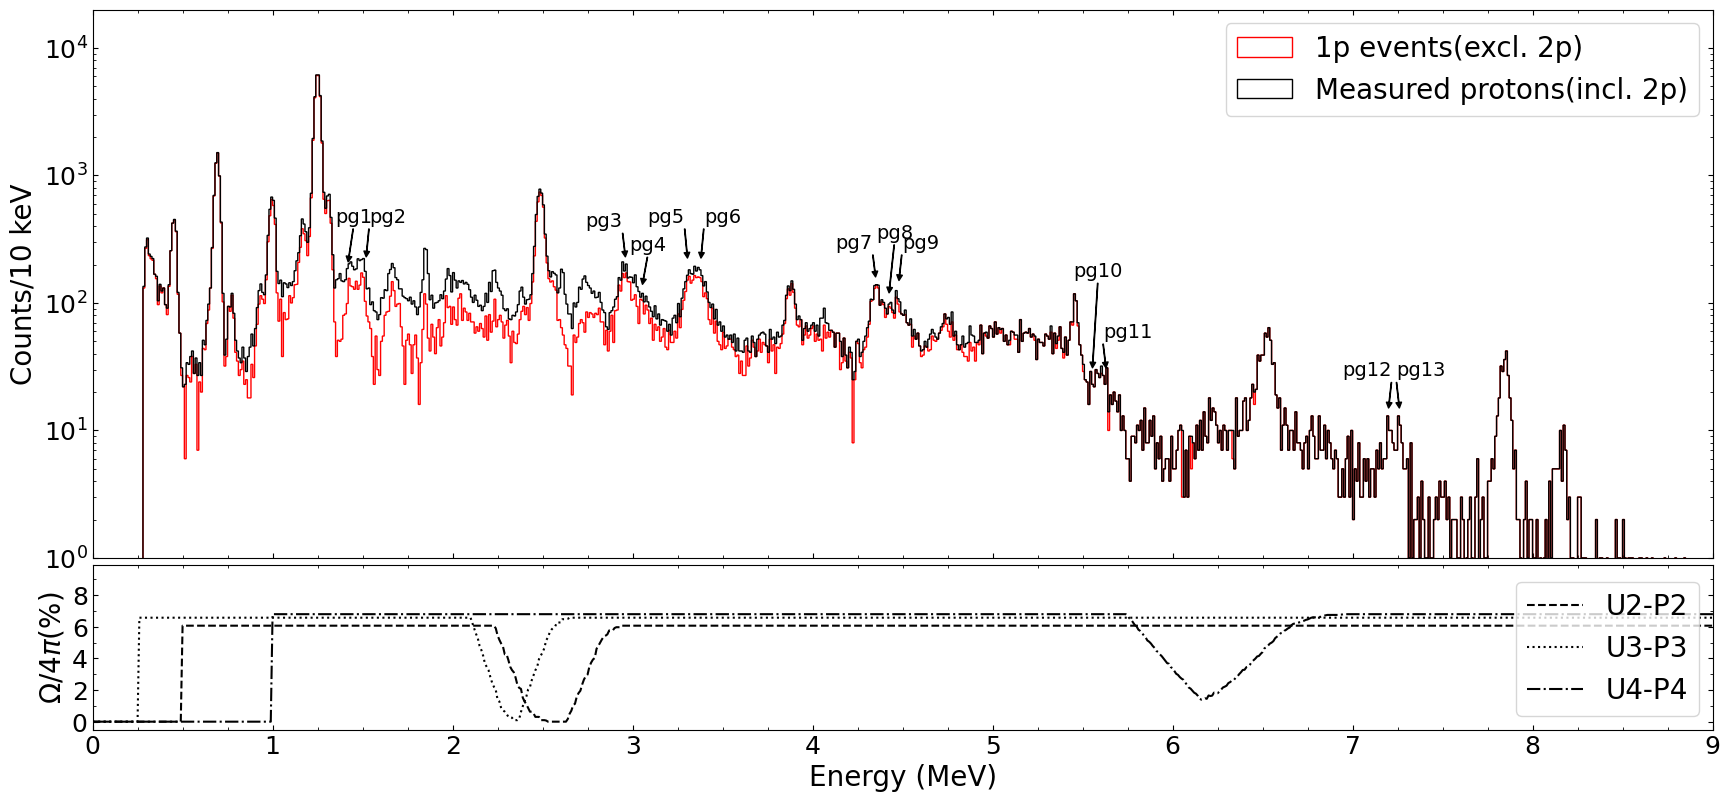

In [18]:
fs = 20
fs_ticks = 18
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(18, 8),gridspec_kw={'height_ratios': [1, 0.3]},sharex=True)
plt.subplots_adjust(hspace=0.02, top=0.96, bottom=0.06, left=0.08, right=0.98)

twoscale = 100/(np.max(sac2)+np.max(sac3)+np.max(sac4))

ax0 = axes[0]
ax0.hist(E/1e3, bins=np.arange(0, 9+0.01, 0.01), histtype='step', color='r', label="1p events(excl. 2p)")
ax0.hist(E2/1e3, bins=np.arange(0, 9+0.01, 0.01), histtype='step', color='k', label="Measured protons(incl. 2p)")
ax0.set_ylabel("Counts/10 keV", fontsize=fs)
ax0.set_yscale('log')
ax0.legend(fontsize=fs, loc='upper right')
ax0.tick_params(axis='x', bottom=True, top=True, labelbottom=False, labeltop=False, labelsize=fs_ticks, direction='in')


ax1 = axes[1]
ax1.plot(Elin/1e3, sac2, 'k--', label='U2-P2')
ax1.plot(Elin/1e3, sac3, 'k:',  label='U3-P3')
ax1.plot(Elin/1e3, sac4, 'k-.', label='U4-P4')
ax1.set_xlabel("Energy (MeV)", fontsize=fs)
ax1.set_ylabel(r"$\Omega$/4$\pi$(%)", fontsize=fs)
ax1.legend(fontsize=fs, loc='lower right')
ax1.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=fs_ticks, direction='in')
ax1.tick_params(axis='y', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=fs_ticks, direction='in')
ax1.set_yticks(np.arange(0,10,1), minor=True)
ax1.set_yticks(np.arange(0,10,2))
ax1.set_xticks(np.arange(-1,10,1))
ax1.set_xticks(np.arange(-1,10,0.25), minor=True)

ax1.set_ylim(-0.5,9.9)
ax0.set_xlim(0, 9)
ax0.set_ylim(1, 2e4)

ax0.tick_params(axis='both', which='major', labelsize=fs_ticks, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=fs_ticks, direction='in')

trues = [1425, 1500, 2970, 3055, 3315, 3380, 4350,4425,4470, 5555, 5630, 7200, 7260]
trues_err = [15, 20, 30, 30, 25, 30, 25, 15, 15, 20, 20, 20, 20]
es = [1.42, 1.52,2.960,3.055, 3.305, 3.380, 4.350, 4.425, 4.48, 5.555, 5.630, 7.2, 7.26]
arrow = [(0.21*1e3,0.4*1e3, "cent"), (0.23*1e3,0.4*1e3, "right"), (2.3e2, 3.7e2, "left"), (1.4e2, 2.4e2, "cent")
         , (2.25e2, 4e2, "left"), (2.25e2, 4e2, "right"), (1.6e2, 2.5e2, "left"), (1.2e2, 3e2, "cent"),(1.5e2, 2.5e2, "right"),
         (3.1e1, 1.5e2, "cent"), (3.1e1, 5e1, "right"), (1.5e1, 2.5e1, "left"), (1.5e1, 2.5e1, "right")]
i = 1
for e,a in zip(es,arrow):
    if isinstance(a, tuple):
        if a[2] == "left":
            ax0.annotate(f"pg{i}", xy=(e, a[0]), xytext=(e-0.12, a[1]), arrowprops=dict(facecolor='k', edgecolor='k', width=0.3, headwidth=4, headlength=4), ha='center', va='bottom', fontsize=14, color='k')
        if a[2] == "right":
            ax0.annotate(f"pg{i}", xy=(e, a[0]), xytext=(e+0.12, a[1]), arrowprops=dict(facecolor='k', edgecolor='k', width=0.3, headwidth=4, headlength=4), ha='center', va='bottom', fontsize=14, color='k')
        if a[2] == "cent":
            ax0.annotate(f"pg{i}", xy=(e, a[0]), xytext=(e+0.03, a[1]), arrowprops=dict(facecolor='k', edgecolor='k', width=0.3, headwidth=4, headlength=4), ha='center', va='bottom', fontsize=14, color='k')
    else:
        ax0.annotate(f"pg{i}", xy=(e, a), ha='center', va='bottom', fontsize=14, color='k')#, xytext=(e, a[1]), arrowprops=dict(facecolor='k', edgecolor='k', width=0.3, headwidth=4, headlength=4))
    i+=1

plt.savefig("pgsingles.pdf")
plt.show()

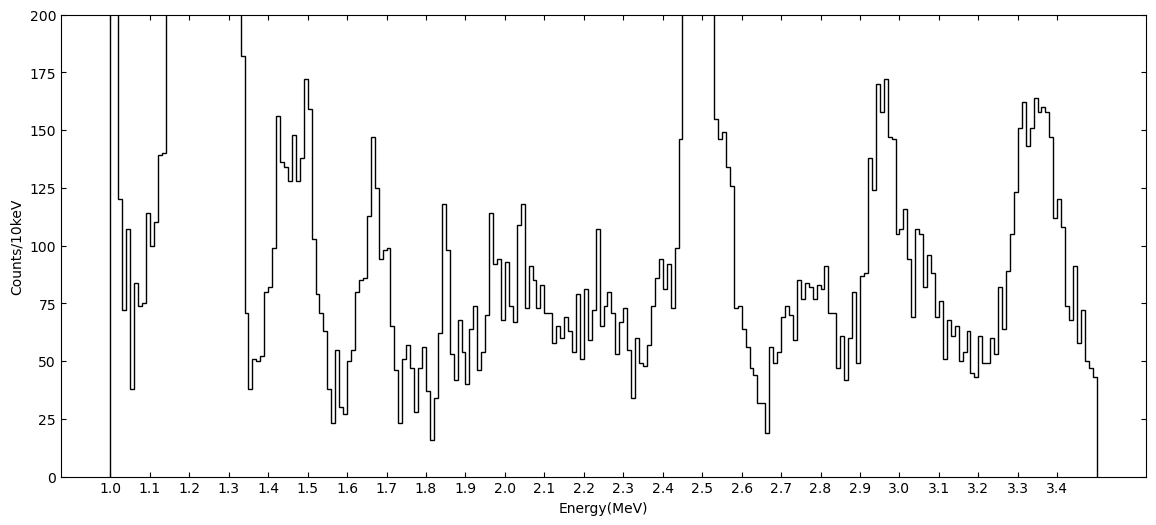

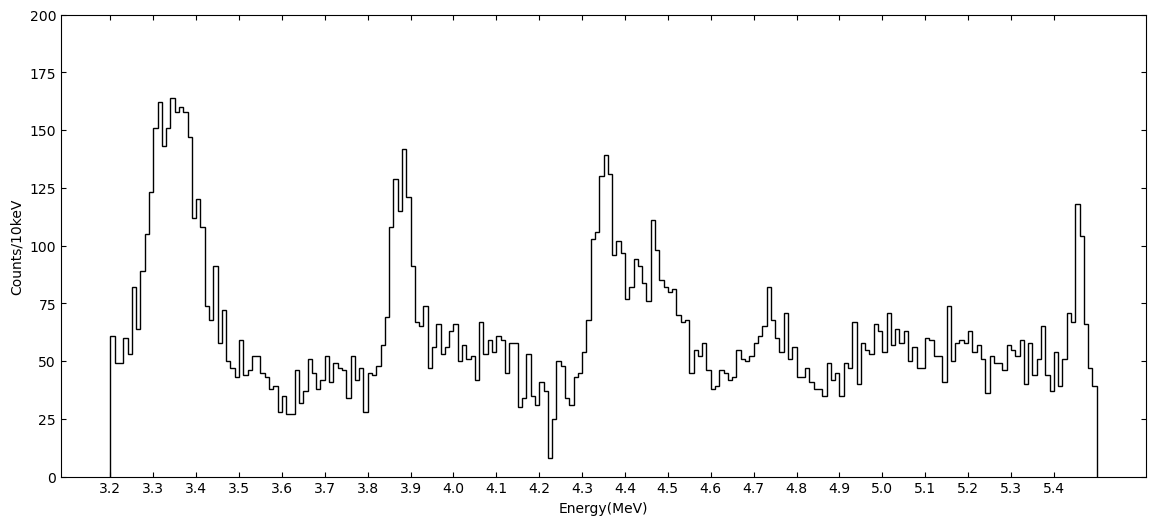

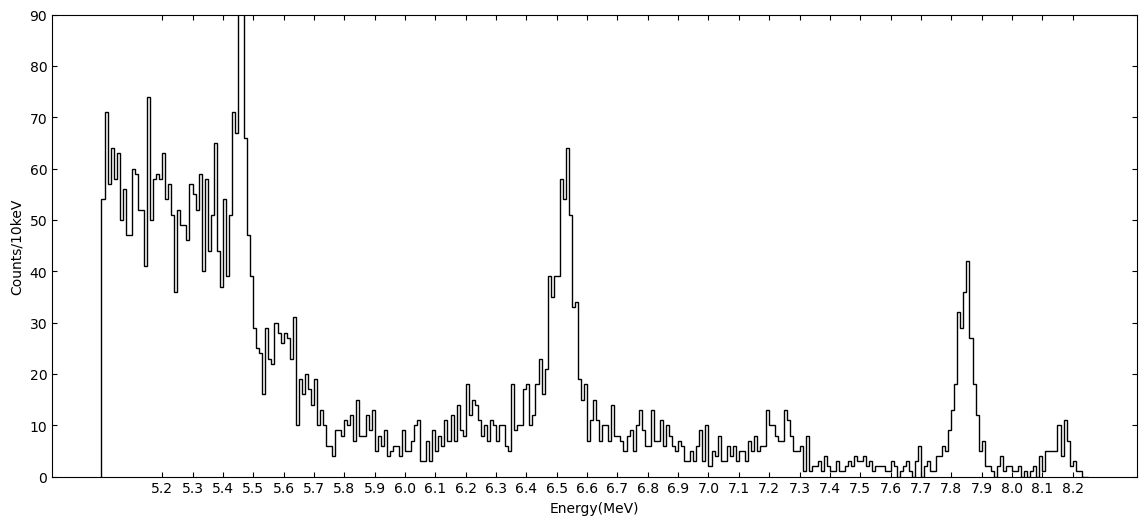

In [8]:

plt.figure(figsize=(14,6))
plt.hist(E/1e3, bins=np.arange(1, 3.5+0.01, 0.01), histtype='step', color='k', label="1p events(excl. 2p)")
plt.xlabel("Energy(MeV)")
plt.ylabel("Counts/10keV")
plt.yscale('linear')
plt.xticks(np.arange(1,3.5,0.1))
plt.ylim(0,200)
#plt.savefig("Espec1.pdf")

plt.figure(figsize=(14,6))
plt.hist(E/1e3, bins=np.arange(3.2, 5.5+0.01, 0.01), histtype='step', color='k', label="1p events(excl. 2p)")
plt.xlabel("Energy(MeV)")
plt.ylabel("Counts/10keV")
plt.yscale('linear')
plt.xticks(np.arange(3.2,5.5,0.1))
plt.ylim(0,200)
#plt.savefig("Esepc2.pdf")

plt.figure(figsize=(14,6))
plt.hist(E/1e3, bins=np.arange(5, 8.25+0.01, 0.01), histtype='step', color='k', label="1p events(excl. 2p)")
plt.xlabel("Energy(MeV)")
plt.ylabel("Counts/10keV")
plt.yscale('linear')
plt.xticks(np.arange(5.2, 8.25,0.1))
plt.ylim(0,90)
plt.savefig("Esepc3.pdf")

In [9]:
######### Peak values read from id3 spectrum very roughly
import numpy as np
frac = 0.9542011788469517 # (Na21/(p+Na21)) amount of energy the daughter nucleus gets of the total energy released in the decay
frac_err = 1.032071836027589e-10 # uncertainty of the fraction
psep = 5.50410 # proton separation energy of 22Mg
psep_err = 0.00016 # error of proton separation energy of 22Mg
trues = np.array([1430, 1500, 2970, 3050, 3310, 3380, 4350,4420,4470, 5560, 5630, 7200, 7260])/1e3
trues_err = np.array([20, 30, 30, 30, 30, 30, 30, 20, 20, 30,30,30,30])/1e3

gammas = [4,3,2,2,1,1,1,3,1,2,2,0,0]

def trueE(E,Eerr, gamma=0):
    addon = 0
    if gamma==1:
        addon = 332
    if gamma==2:
        addon = 332+1384
    if gamma==3:
        addon = 332+1384+1113
    if gamma==4:
        addon = 332+1384+1113+1590
    if gamma>4:
        return "aint no gamma that big"
    TE = E/frac+psep+addon/1e3
    TE_err = np.sqrt((1/frac * Eerr)**2 + (E/(frac**2) * frac_err)**2 + (1/frac * psep_err)**2)

    return TE, TE_err, gamma

for i,j,g in zip(trues, trues_err,gammas):
    ts = trueE(i,j,g)
    print(f"Read proton E: {i:.2f} -- Deduced Ex22Mg: {ts[0]:.2f}({ts[1]*1e3:.0f})")

Read proton E: 1.43 -- Deduced Ex22Mg: 11.42(21)
Read proton E: 1.50 -- Deduced Ex22Mg: 9.91(31)
Read proton E: 2.97 -- Deduced Ex22Mg: 10.33(31)
Read proton E: 3.05 -- Deduced Ex22Mg: 10.42(31)
Read proton E: 3.31 -- Deduced Ex22Mg: 9.30(31)
Read proton E: 3.38 -- Deduced Ex22Mg: 9.38(31)
Read proton E: 4.35 -- Deduced Ex22Mg: 10.39(31)
Read proton E: 4.42 -- Deduced Ex22Mg: 12.97(21)
Read proton E: 4.47 -- Deduced Ex22Mg: 10.52(21)
Read proton E: 5.56 -- Deduced Ex22Mg: 13.05(31)
Read proton E: 5.63 -- Deduced Ex22Mg: 13.12(31)
Read proton E: 7.20 -- Deduced Ex22Mg: 13.05(31)
Read proton E: 7.26 -- Deduced Ex22Mg: 13.11(31)
